In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ujipenchars2
import string
from preprocessing import DrawingToBoxScaler, VideoCreator, GradientCreator, create_gradient

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)

drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
train = drawing_scaler.transform(train)
test = drawing_scaler.transform(test)

data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([int(drawing.label) for drawing in data], dtype=np.int8)

In [3]:
def plot_images(images: np.ndarray):
    n = len(images)
    plt.figure(figsize=(3*n, 3))

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="binary", vmin=0, vmax=255)
        axes = plt.gca().axes
        axes.xaxis.set_ticks([])
        axes.yaxis.set_ticks([])

    plt.show()

In [4]:
import tensorly as tl
from tensorly.decomposition import tucker
import pandas as pd
from math import prod

# Prva dimenzija od X mora biti veličina skupa podataka.
#   cuts - granice normi za rezanje dimenzija matrice S u različitimo modovima (i matrica U)
class HOSVDClassifier:
    def __init__(self, cuts=None):
        self.labels = None  # Svi labeli
        self.A = []  # Ortonormirani tenzori iz dekompozicije složeni u 1 tenzor za svaki label
        self.k = None  # Broj labela
        self.cores = []  # S-ovi iz dekompozicije tenzora
        self.shape = None  # Dimenzije pojedinih podataka
        self.cuts = cuts

    def fit(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        X = X.astype(np.float64)
        self.shape = X.shape[1:]
        self.labels, inverse = np.unique(y, return_inverse=True)
        self.k = len(self.labels)
        for i in range(self.k):
            # Tenzor za fiksni label
            tensor = X[inverse == i]
            n = tensor.shape[0]
            rank = (min(n, prod(self.shape)),) + self.shape # Odrežemo prvu dimenziju
            core, factors = tl.decomposition.tucker(tensor, rank=rank) # HOSVD dekompozicija
            self.cores.append(core)

            # Rezanje
            if self.cuts is not None:
                assert core.ndim == len(self.cuts)
                core_shape_new = self.new_shape(core)
                for i in range(core.ndim):
                    factors[i] = factors[i][:core.shape[i], :core_shape_new[i]]
                core = core[tuple(slice(i) for i in core_shape_new)]

            A = tl.tenalg.multi_mode_dot(core, factors, skip=0) # Tenzor sa svim A-ovima
            norms = tl.norm(A, axis=tuple(range(1, A.ndim))) # Norme A-ova
            A /= norms[(slice(None),) + (None,)*(A.ndim - 1)] # Normiramo A-ove
            self.A.append(A)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = X.astype(np.float64)
        n = X.shape[0]
        squared_projection_norms = np.empty((n, self.k), dtype=np.float64) # Kvadrati normi projekcija na A-ove
        for i in range(n):
            Z = X[i]
            for j in range(self.k):
                squared_projection_norms[i, j] = (tl.tenalg.inner(self.A[j], Z, Z.ndim)**2).sum()
        return self.labels[squared_projection_norms.argmax(axis=1)]

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        return sum(self.predict(X) == y) / X.shape[0]

    def norms(self, S, mod):
        axis = tuple(range(mod)) + tuple(range(mod + 1, S.ndim))
        return tl.norm(S, axis=axis)

    def new_shape(self, core):
        shape = list(core.shape)
        for i in range(core.ndim):
            norms = self.norms(core, i)
            if norms[-1] < self.cuts[i]:
                shape[i] = np.argmax(norms < self.cuts[i])
        return tuple(shape)

    def plot_cuts(self):
        ndim = len(self.shape) + 1
        nrow = (ndim + 1) // 2
        plt.figure(figsize=(14, 6*nrow))
        plt.suptitle('Norme odsječaka jezgrenih tenzora u različitim modovima', fontsize=20)
        for mod in range(0, ndim):
            plt.subplot(nrow, 2, mod + 1)
            plt.title(f'Mod {mod}')
            for label in range(self.k):
                for i in range(self.cores[label].shape[mod]):
                    plt.semilogy(self.norms(self.cores[label], mod), color='black')
            if self.cuts is not None:
                ylim = plt.ylim()
                plt.axhline(self.cuts[mod], color='red')
                plt.ylim(ylim)
        plt.show()

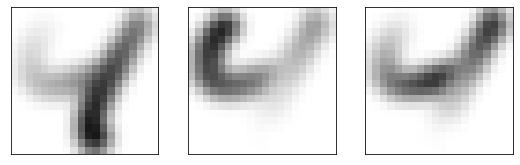

In [5]:
# Primjer izrade gradijenta
gradient_creator = GradientCreator(
    gradients = [
        create_gradient([(0, 0), (1, 255)], 100), # bijela -> crna
        create_gradient([(0, 255), (1, 0)], 100), # crna -> bijela
        create_gradient([(0, 0), (0.5, 255), (1, 0)], 100), # bijela -> crna -> bijela
    ],
    clip=(-0.15, 1.15, -0.15, 1.15),
    size=(20, 20),
    blur_radius=1,
)
plot_images(gradient_creator.transform_one(data[8]))

In [6]:
%%time
gradients = gradient_creator.transform(data)
# gradients = gradients.reshape((1200, 3, 400))

CPU times: user 196 ms, sys: 85 ms, total: 281 ms
Wall time: 968 ms


In [7]:
%%time
cls = HOSVDClassifier([400]*4)
cls.fit(gradients[train_idx], labels[train_idx])
cls.score(gradients[test_idx], labels[test_idx])

CPU times: user 12.6 s, sys: 31.1 s, total: 43.7 s
Wall time: 3.06 s


0.9825

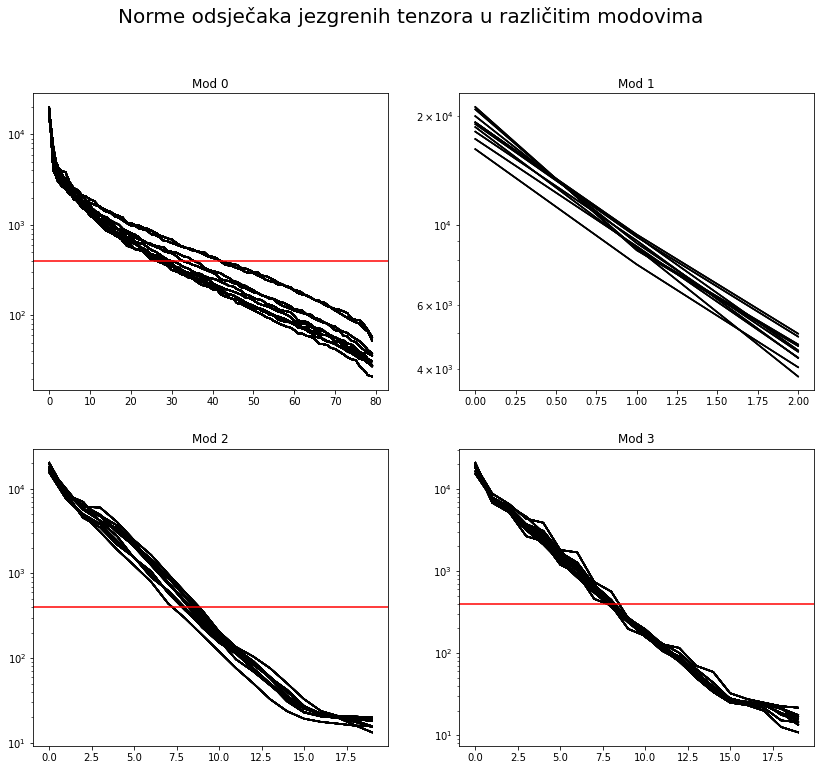

In [8]:
cls.plot_cuts()